In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
group = 9
student = 3

def load_json(group,student,frame):
    with open(f'data/generated/{group}-{student}-{frame}.json') as f:
        return json.load(f)
    
def load_images(group,student,frame):
    return np.array(cv2.imreadmulti(f'data/droplets/{group}-{student}-{frame}.tif', flags=cv2.IMREAD_GRAYSCALE)[1])

def load_all_images(group,student):
    return np.array(cv2.imreadmulti(f'data/sequences/{group}-{student}.tif', flags=cv2.IMREAD_GRAYSCALE)[1])


def process_images(images, back):
    def get_mask(image, back):
        return np.abs(image - back) / np.max(image) > 0.1

    masks = Parallel(n_jobs=8)(delayed(get_mask)(image, back) for image in images)
    masks = np.array(masks)
    masks = masks.astype(np.uint8) * 255
    return masks

def get_contours(masks, frame):
    def clean_frame(mask):
        image = mask.copy()
        image = cv2.medianBlur(image, 3)
        
        kernel = np.ones((3,3),np.uint8)
        image = cv2.dilate(image, kernel, iterations=9)

        image = cv2.medianBlur(image, 17)

        contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        image = np.zeros(image.shape)
        bb = []
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                cv2.drawContours(image, [contour], 0, (255), -1)
                x, y, w, h = cv2.boundingRect(contour)
                bb.append((x, y, w, h))
                cv2.rectangle(image, (x, y), (x+w, y+h), (255), 2)

    
        kernel = np.ones((100,100),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        image = np.array(image, dtype=np.uint8)
        return image

    def get_boundaries(mask):
        boundaries = np.zeros(mask.shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                cv2.drawContours(boundaries, [contour], 0, (255), 5)
        return np.array(boundaries, dtype=np.uint8)

    def get_circles(mask):
        return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=1, minDist=500, param1=50, param2=20, minRadius=270, maxRadius=350)

    def get_bounding_boxes(mask):
        circles = get_circles(mask)
        bb = []
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0,:]:
                x, y, r = circle
                x = int(x)
                y = int(y)
                r = int(r)
                if x-r < 0 or y-r < 0 or x+r > mask.shape[1] or y+r > mask.shape[0]:
                    continue
                bb.append((x-r, y-r, 2*r, 2*r))
        return bb
    
    mask = masks[frame-1]
    mask = clean_frame(mask)
    mask = get_boundaries(mask)
    bb   = get_bounding_boxes(mask)
    return mask, bb

def clean_frame(mask):
    image = mask.copy()
    image = cv2.medianBlur(image, 3)
    
    kernel = np.ones((3,3),np.uint8)
    image = cv2.dilate(image, kernel, iterations=9)

    image = cv2.medianBlur(image, 17)

    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = np.zeros(image.shape)
    bb = []
    for contour in contours:
        if cv2.contourArea(contour) > 300:
            cv2.drawContours(image, [contour], 0, (255), -1)
            x, y, w, h = cv2.boundingRect(contour)
            bb.append((x, y, w, h))
            cv2.rectangle(image, (x, y), (x+w, y+h), (255), 2)


    kernel = np.ones((100,100),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    image = np.array(image, dtype=np.uint8)
    return image

def get_circles_bis(mask):
    return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=20, minRadius=10, maxRadius=30)
def get_circles_ter(mask):
    return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT_ALT, dp=1.5, minDist=20, param1=500, param2=0.01, minRadius=10, maxRadius=30)


In [3]:
images = load_all_images(group,student)
masks = np.zeros(images.shape)
back = np.mean(images,axis=0)
#plt.imshow(back,cmap='gray');


masks = process_images(images, back)
#plt.imshow(masks[0],cmap='gray');

80
Number of cells: 80


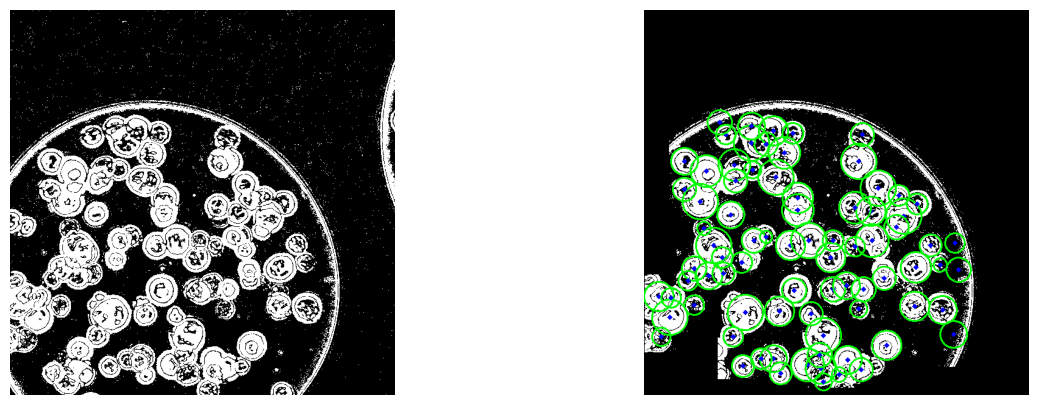

In [4]:
frames = 1
mask, bb = get_contours(masks, frames-1)

shrinked = []
for x, y, w, h in bb:
    shrinked.append(masks[frames-1][y:y+h, x:x+w])

bb = 0

image_copy = shrinked[bb].copy()
clean = clean_frame(shrinked[bb])

contours, _ = cv2.findContours(clean, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ellipse = cv2.fitEllipse(contours[0],)

cv2.ellipse(image_copy, ellipse, (255, 0, 0), 2);
plots = [image_copy]

cleaned_mask = shrinked[bb].copy()
for i in range(cleaned_mask.shape[0]):
    for j in range(cleaned_mask.shape[1]):
        #if i,j is in the contour
        if not cv2.pointPolygonTest(contours[0], (j,i), False) > 0:
            cleaned_mask[i,j] = 0

to_plot = []
circle_mask = cleaned_mask
WhiteThreshold = 0

# Find circles in the cleaned mask

circles = get_circles_bis(circle_mask)
to_plot.append(shrinked[bb])

print(len(circles[0]))

# Check if circles are found
if circles is not None:
    # Get the number of cells
    num_cells = len(circles[0])
    print("Number of cells:", num_cells)
else:
    print("No circles found in the cleaned mask.")

# Draw the circles on the original image
final = cv2.cvtColor(circle_mask, cv2.COLOR_GRAY2RGB)

if circles is not None:
    circles = np.uint16(np.around(circles))

    for circle in circles[0,:]:
        x, y, r = circle
        x = int(x)
        y = int(y)
        r = int(r)
        if np.sum(circle_mask[y-r:y+r, x-r:x+r])/(2*r)**2 < 255*WhiteThreshold:
            continue
        cv2.circle(final, (x, y), r, (0, 255, 0), 2)
        cv2.circle(final, (x, y), 2, (0, 0, 255), 3)

# Display the result
to_plot.append(final)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(to_plot[i], cmap='gray')
    ax.axis('off')
plt.show()


In [5]:
# load json 9_3_14 and find the number of cells
with open(f'data/all_json/{group}_{student}.json') as f:
    data = json.load(f)

all_cell_count = []
frame = 14

for frame in range(1,31):
    cell_count = []
    curr_dat = np.array(data[f'9_3_frame_{frame}']["cells"])

    cell_ids = np.unique(curr_dat[:,2])

    # find the number of cells for each cell_id

    for cell_id in cell_ids:
        cell_count.append(np.sum(curr_dat[:,2] == cell_id))

    all_cell_count.append(cell_count)

print(all_cell_count)


[[120, 97], [99, 84], [95, 81], [98, 81, 118], [89, 116], [89, 113, 95], [109, 93], [112, 81, 107], [87, 100], [101], [113, 85], [82], [78, 97], [78, 93, 112], [96, 104], [97, 107, 107], [106, 93], [110, 109], [103, 92], [107, 93], [97, 87], [96, 90], [83, 84, 100], [86, 91], [88, 93, 99], [92, 96], [97, 94, 97], [90, 92], [88], [90, 92]]


In [6]:
# Apply the method to the images
WhiteThreshold = 0
all_cell_count_cv = []
cell_count_frame_cv = []



for frame in tqdm(range(1,31)):

    # cut images and find boxes
    cell_count_frame_cv = []
    shrinked = []
    mask, bb = get_contours(masks, frame)

    #print(bb)
    for x, y, w, h in bb:
        shrinked.append(masks[frame-1][y:y+h, x:x+w])
    
    for bb in range(len(shrinked)):
        
        #load mask of the current box
        clean = clean_frame(shrinked[bb])
        contours, _ = cv2.findContours(clean, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


        #check larger contour by area
        max_area = 0
        max_contour = None
        for contour in contours:
            if cv2.contourArea(contour) > max_area:
                max_area = cv2.contourArea(contour)
                max_contour = contour


        ellipse = cv2.fitEllipse(max_contour,)
        cleaned_mask = shrinked[bb].copy()
        for i in range(cleaned_mask.shape[0]):
            for j in range(cleaned_mask.shape[1]):
                #if i,j is in the contour
                if not cv2.pointPolygonTest(max_contour, (i,j), False) > 0:
                    cleaned_mask[i,j] = 0
        
        circle_mask = cleaned_mask

        """
        # draw ellipse on cleaned mask
        cv2.ellipse(cleaned_mask, ellipse, (255, 0, 0), 2);
        plt.imshow(cleaned_mask, cmap='gray')
        plt.show() """
        

        circles = get_circles_bis(circle_mask)
        to_plot.append(shrinked[bb])
        # Check if circles are found
        if circles is not None:
            # Get the number of cells
            num_cells = len(circles[0])
        else:
            num_cells = 0
        cell_count_frame_cv.append(num_cells)
    all_cell_count_cv.append(cell_count_frame_cv)

print(all_cell_count_cv)
        

100%|██████████| 30/30 [00:53<00:00,  1.78s/it]

[[91, 106], [93, 92], [86, 92], [113, 83], [84, 112], [80, 104, 93], [100, 87], [106, 99, 86], [98, 87], [90], [101, 93], [79], [94, 76], [77, 84, 90], [82, 99], [97, 80, 83], [100, 95], [95], [96, 97], [83, 89], [83], [76, 96], [81, 79, 105], [81, 91], [92, 79, 92], [81, 78], [93, 85], [86, 83], [79], [88, 92]]


Different number of boxes at frame:  3
Different number of boxes at frame:  17
Different number of boxes at frame:  20
Different number of boxes at frame:  26


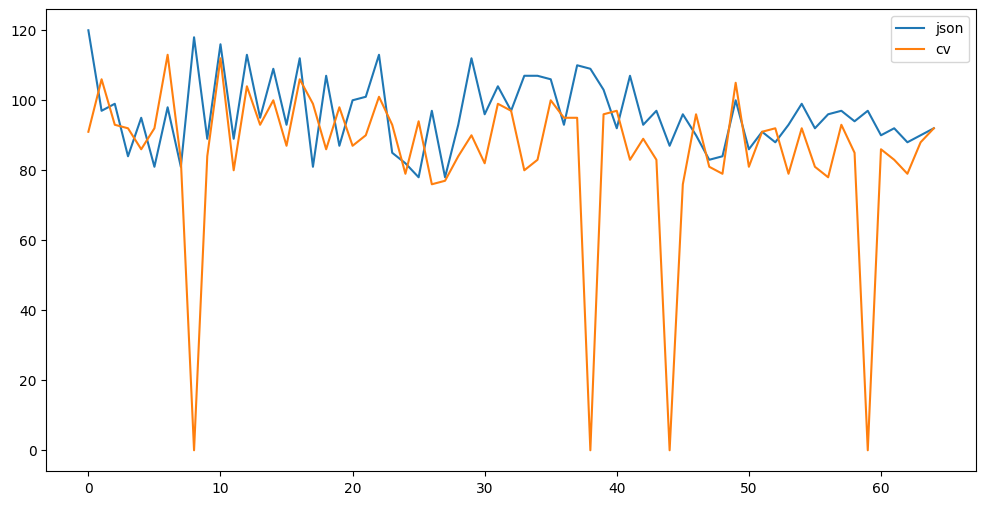

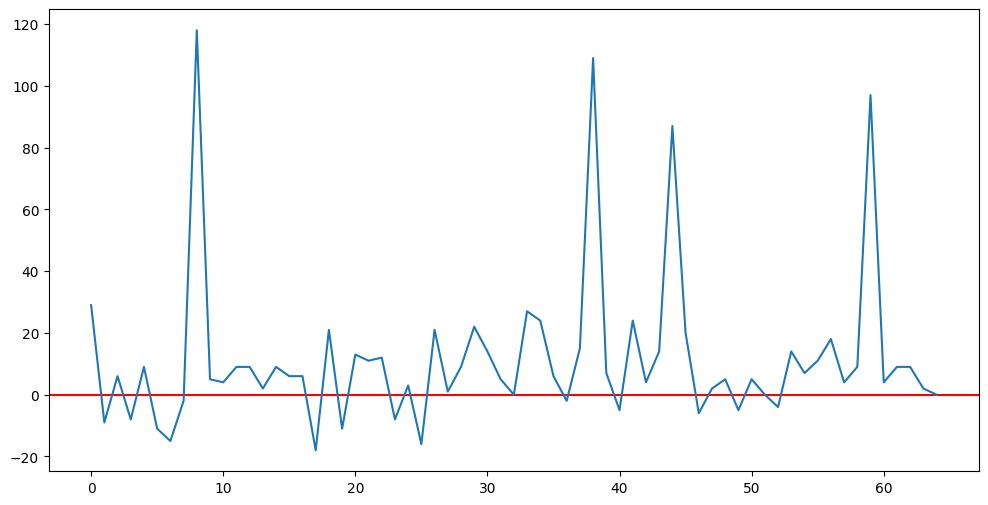

11.646153846153846


In [7]:
# compare the result to the json
one_line = []
one_line_cv = []
for i in range(len(all_cell_count_cv)):
    if len(all_cell_count_cv[i]) != len(all_cell_count[i]):
        print("Different number of boxes at frame: ", i)
    for j in range(len(all_cell_count[i])):
        if j >= len(all_cell_count_cv[i]):
            one_line_cv.append(0)
        else:
            one_line_cv.append(all_cell_count_cv[i][j])
        one_line.append(all_cell_count[i][j])

plt.figure(figsize=(12, 6)) 
plt.plot(one_line, label="json")
plt.plot(one_line_cv, label="cv")
plt.legend()
plt.show()

diff = np.array(one_line) - np.array(one_line_cv)
plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='red')
plt.plot(diff)
plt.show()

print(np.mean(diff))




## Chargement a partir des petits json

In [12]:
def load_json(group,student,frame):
    with open(f'data/generated/{group}-{student}-{frame}.json') as f:
        return json.load(f)
    
def load_images(group,student,frame):
    return cv2.imreadmulti(f'data/droplets/{group}-{student}-{frame}.tif', flags=cv2.IMREAD_GRAYSCALE)[1]


In [13]:
def get_circles_bis(mask):
    return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=20, minRadius=10, maxRadius=30)

In [14]:
def search_cell(image):
    
    cells_found = []
    #load mask of the current box
    clean = clean_frame(image)
    cleaned_mask = image.copy()
    
    contours, _ = cv2.findContours(clean, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #check larger contour by area
    max_area = 0
    max_contour = None
    for contour in contours:
        if cv2.contourArea(contour) > max_area:
            max_area = cv2.contourArea(contour)
            max_contour = contour

    ellipse = cv2.fitEllipse(max_contour,)
    black = np.zeros_like(cleaned_mask)
    cv2.ellipse(black, ellipse, (255, 255, 255), -1)
    contour_ellipse, _ = cv2.findContours(black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



    cleaned_mask = image.copy()
    for i in range(cleaned_mask.shape[0]):
        for j in range(cleaned_mask.shape[1]):
            #if i,j is in the contour
            if not cv2.pointPolygonTest(contour_ellipse[0], (i,j), False) > 0:
                cleaned_mask[i,j] = 0
    
    """ 
    circles = cv2.HoughCircles(cleaned_mask, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=250, maxRadius=400)
    mask = np.zeros_like(cleaned_mask)
    if circles is not None:
        circle = np.array(circles[0][0], dtype=int)
        mask = cv2.circle(mask, (circle[0],circle[1]), circle[2], (255, 255, 255), -1)
        cleaned_mask = cv2.bitwise_and(cleaned_mask, mask)
    """
    
    circle_mask = cleaned_mask
    
    cells_found = get_circles_bis(circle_mask)[0]
    return cells_found

  0%|          | 0/1 [00:00<?, ?it/s]

Large different number of cells at group:  9  student:  3 frame:  1  and index:  1 Differenc:  14


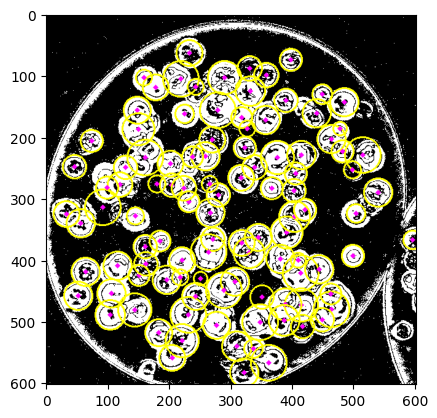

Large different number of cells at group:  9  student:  3 frame:  3  and index:  1 Differenc:  11


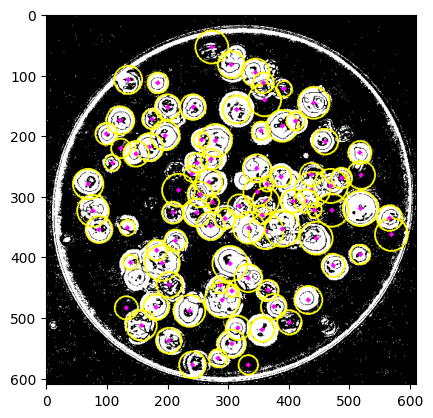

Large different number of cells at group:  9  student:  3 frame:  8  and index:  1 Differenc:  13


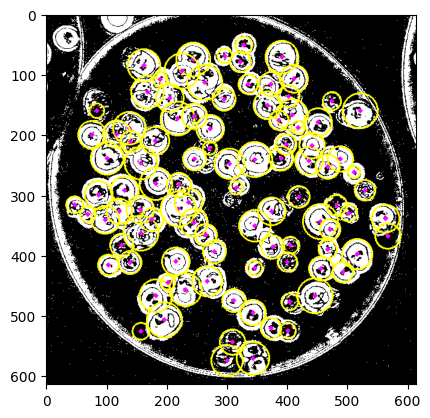

Large different number of cells at group:  9  student:  3 frame:  10  and index:  0 Differenc:  11


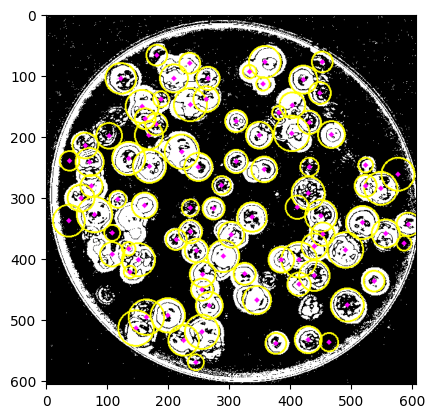

Large different number of cells at group:  9  student:  3 frame:  11  and index:  0 Differenc:  12


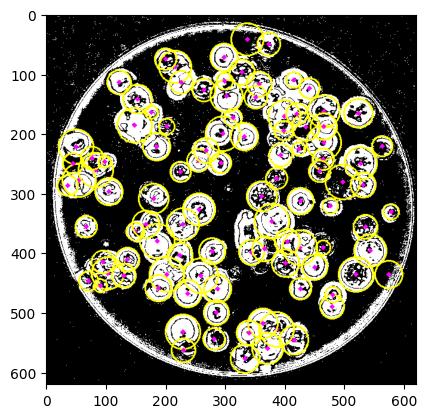

Large different number of cells at group:  9  student:  3 frame:  14  and index:  2 Differenc:  20


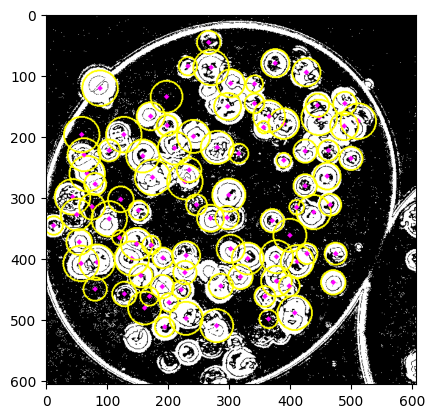

Large different number of cells at group:  9  student:  3 frame:  16  and index:  1 Differenc:  17


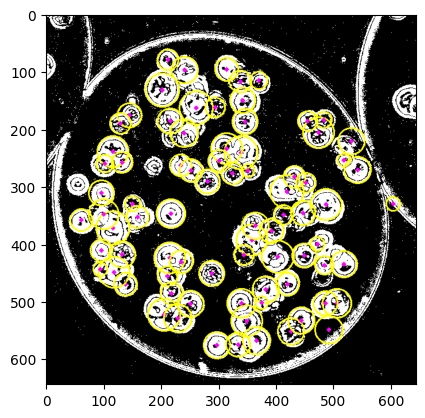

Large different number of cells at group:  9  student:  3 frame:  16  and index:  2 Differenc:  20


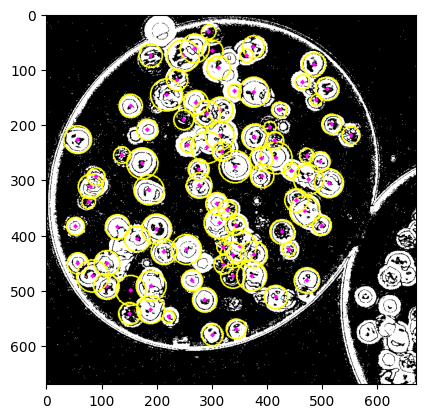

Large different number of cells at group:  9  student:  3 frame:  17  and index:  1 Differenc:  11


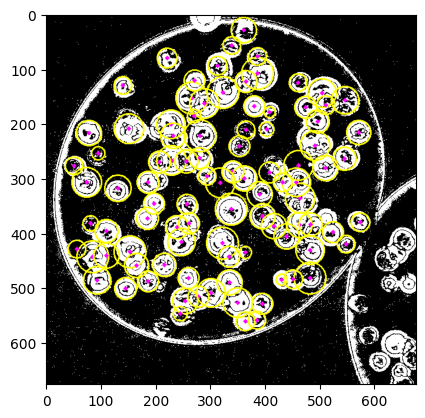

Large different number of cells at group:  9  student:  3 frame:  18  and index:  0 Differenc:  14


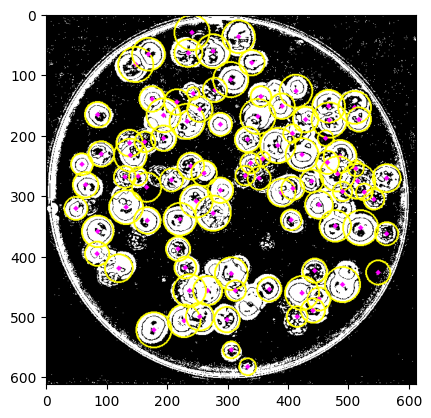

Large different number of cells at group:  9  student:  3 frame:  20  and index:  1 Differenc:  19


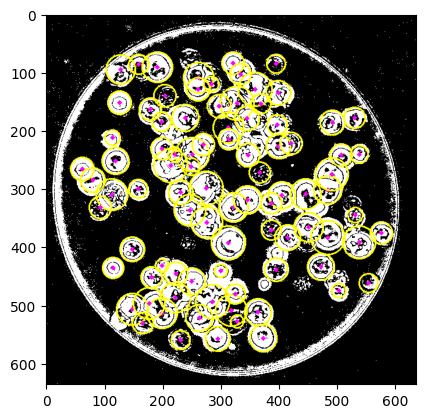

Large different number of cells at group:  9  student:  3 frame:  21  and index:  0 Differenc:  14


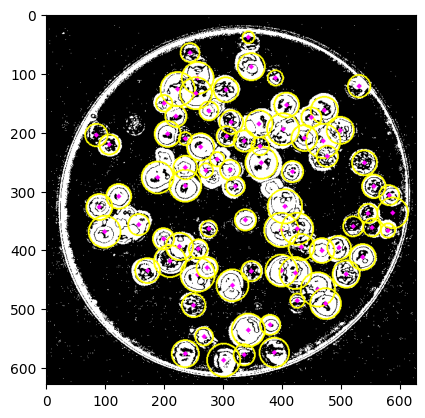

Large different number of cells at group:  9  student:  3 frame:  22  and index:  0 Differenc:  20


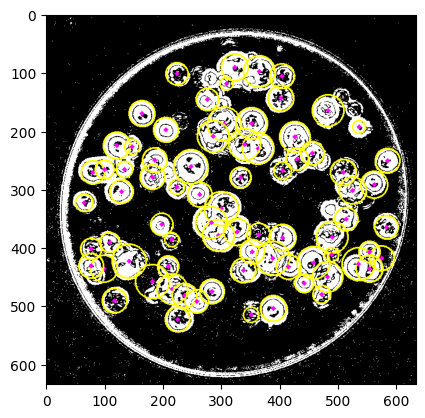

Large different number of cells at group:  9  student:  3 frame:  26  and index:  1 Differenc:  13


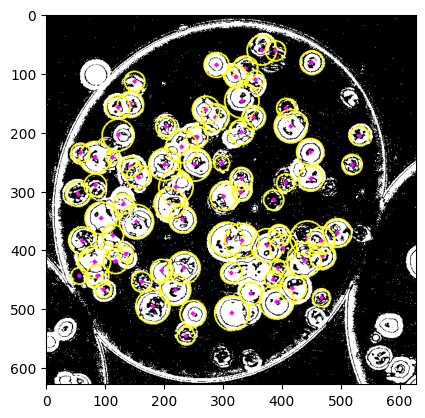

100%|██████████| 1/1 [00:45<00:00, 45.01s/it]

[[[[[97, 91, array([ 1.22786595, -2.33766725])], [120, 106, array([-0.11995646, -2.52406006])]], [[99, 93, array([-2.76066204,  1.54202733])], [84, 92, array([  3.7070327 , -22.84162685])]], [[95, 86, array([13.71052632, -1.50354389])], [81, 92, array([-1.57891959,  2.090031  ])]], [[118, 115, array([-9.34666055, 14.63345854])], [81, 83, array([-17.61259781,  -2.86293689])]], [[89, 84, array([-0.23528916,  4.07144165])], [116, 110, array([-10.02036785,  13.48118013])]], [[89, 80, array([-0.22921959,  6.17176356])], [113, 104, array([-8.34684632, -3.6012711 ])], [95, 97, array([-16.34807065,   0.7592616 ])]], [[109, 99, array([ 2.27371048, -4.02785807])], [93, 89, array([10.69065119, 14.53888858])]], [[107, 106, array([-3.41949007, 21.38078379])], [112, 99, array([4.95437186, 9.17153495])], [81, 89, array([-10.47572685,  27.82890301])]], [[100, 97, array([-14.66989502,   5.73196411])], [87, 86, array([-19.50335413, -11.45548538])]], [[101, 90, array([-8.38779895,  8.18986949])]], [[113,

In [15]:
group_stats = []
for group in tqdm(range(9,10)):
    sudent_stats = []
    for student in range(3,4):
        seq_stats = []
        for frame in range(1,31):
            frame_stats = []
            json_files = load_json(group,student,frame)
            tif = load_images(group,student,frame)
            for i, image in enumerate(tif):
                bb_stats = [] # 0: number of cells, 1: number of cells found
                if json_files["valid_bb"][i] == 0:
                    print("Invalid bb at group: ", group, " student: ", student, "frame: ", frame, " and index: ", i)
                    continue
                current_bb = json_files["bb"][i]
                x, y, w, h = current_bb
                cell = json_files["cell"][i]

                # search for cells
                cells_found = search_cell(image)

                # compare point cloud by comparing the center of mass
                truth = np.mean(cell, axis=0) - np.array([x,y]) #correcting index to box
                found = np.mean(cells_found, axis=0)[0:2]                

                # compare number of cells
                bb_stats.append(len(cell))
                bb_stats.append(len(cells_found))
                bb_stats.append((truth-found))
                if abs(len(cells_found) - len(cell))>10:
                    print("Large different number of cells at group: ", group, " student: ", student, "frame: ", frame, " and index: ", i, "Differenc: ", abs(len(cells_found) - len(cell)))
                    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                    for circle in cells_found:
                        x, y, r = circle
                        x = int(x)
                        y = int(y)
                        r = int(r)
                        cv2.circle(image_color, (x, y), r, (255, 255, 0), 2)
                        cv2.circle(image_color, (x, y), 2, (255, 0, 255), 3)
                    plt.imshow(image_color, cmap='gray')
                    plt.show()


                frame_stats.append(bb_stats)
            seq_stats.append(frame_stats)
        sudent_stats.append(seq_stats)
    group_stats.append(sudent_stats)
print(group_stats)

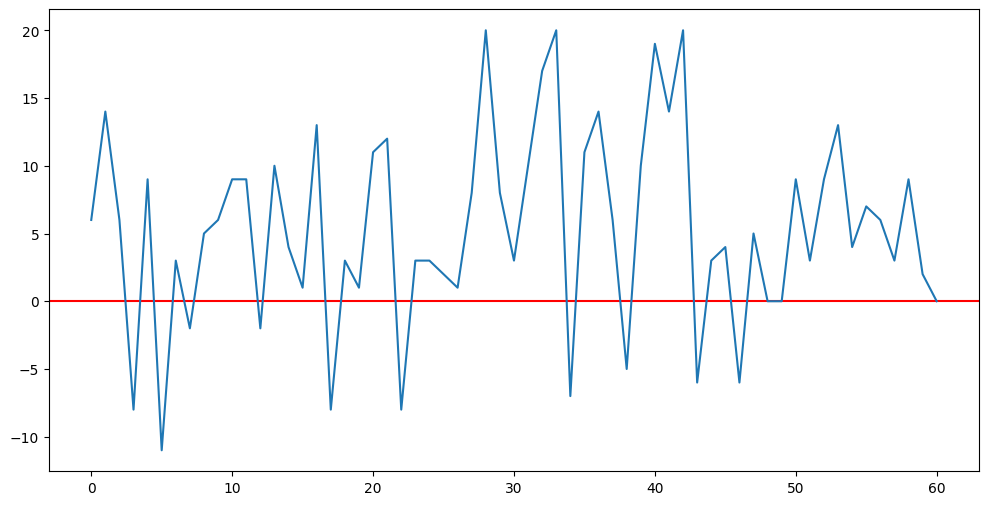

5.327868852459017


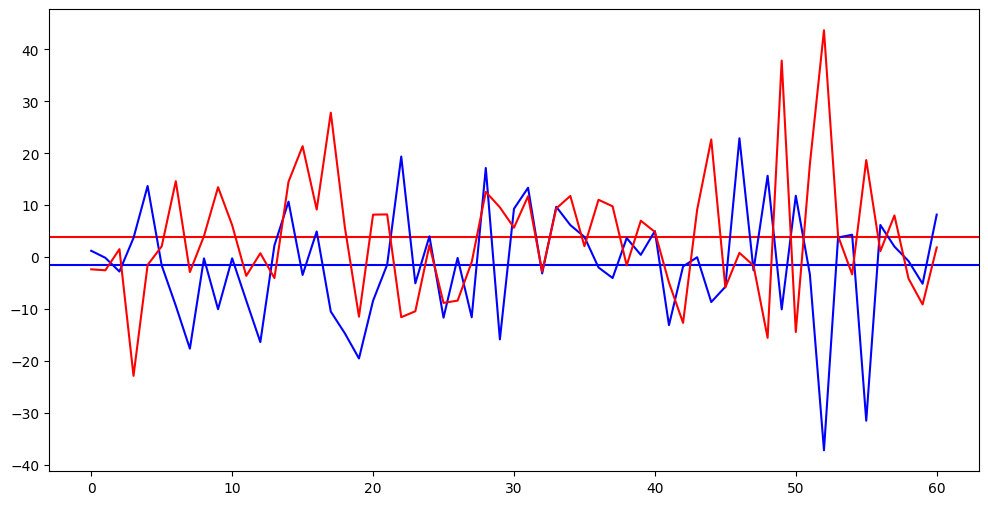

-1.5375308918257264
3.8464841271599512


In [16]:
diff_count = []
diff_center_x = []
diff_center_y = []
group = 9
student = 3

for i in range(0,30):
    for j in range(len(group_stats[0][0][i])):
        diff_count.append(group_stats[0][0][i][j][0] - group_stats[0][0][i][j][1])
        diff_center_x.append(group_stats[0][0][i][j][2][0])
        diff_center_y.append(group_stats[0][0][i][j][2][1])

plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='red')
plt.plot(diff_count)
plt.show()
print(np.mean(diff_count))

plt.figure(figsize=(12, 6))
plt.axhline(y=np.mean(diff_center_y), color='red')
plt.axhline(y=np.mean(diff_center_x), color='blue')
plt.plot(diff_center_x, label="x", color='blue')
plt.plot(diff_center_y, label="y", color='red')
plt.show()
print(np.mean(diff_center_x))
print(np.mean(diff_center_y))

In [17]:
cloud_found = cells_found
cloud_truth = cell
dist_list = []

for point in cloud_found:
    closest = cloud_truth[0]
    min_dist = np.linalg.norm(point[0:2]-closest)
    for truth in cloud_truth:
        dist = np.linalg.norm(point[0:2]-truth)
        if dist < min_dist:
            min_dist = dist
            closest = truth
    #supprimer closest de cloud_truth
    cloud_truth.remove(closest)
    dist_list.append(min_dist)




In [18]:
print(np.mean(dist_list))
print(dist_list)

424.17805767817157
[36.50342449688796, 364.9006714162088, 332.59960913987857, 338.8104189661233, 384.3000130106685, 49.563091106185055, 109.10774491299873, 34.15406271587613, 114.50982490598787, 335.51825583714515, 471.2265909305204, 382.74861201577204, 27.865749586185547, 279.7257585564833, 199.78613565510494, 21.50581316760657, 415.79622412907986, 16.80773631397161, 194.68564405214886, 416.4330678512454, 201.70399103636993, 259.9201800553393, 369.3000135391278, 395.11327489721225, 264.12970298699844, 43.617656975128774, 203.57922290842944, 318.8894792871035, 202.44134953116668, 315.237212270379, 494.4213789876, 470.44287644728985, 226.54469757643855, 526.6559598067794, 398.22418309289054, 431.49333714438745, 465.83097793083704, 246.1960600822036, 612.2503572885851, 347.9259978788593, 461.38324633649194, 253.31107358344997, 356.4161893068271, 595.8762455409681, 528.1879400364987, 459.7961504841031, 264.60253211184505, 386.0861302870125, 423.94162333981785, 536.7443525552924, 356.83679